<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw3/blob/main/NNDL_hw3_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3 - Deep Reinforcement Learning

# Part 3

Prepare enviroment

In [1]:
!pip install gym

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

## Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
# !pip3 install box2d-py

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (128 kB/s)

In [4]:
# !pip install box2d box2d-kengz
# !pip install Box2D
# !pip install -e '.[box2d]'

In [5]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [6]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [9]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [10]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(3, 3, 3, 3), (4, 4, 4, 4)]


## Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

### Network definition

In [11]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim, layer_size):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, layer_size),
                nn.Tanh(),
                nn.Linear(layer_size, layer_size),
                nn.Tanh(),
                nn.Linear(layer_size, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [12]:
class DDQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim, layer_size):
        super().__init__()

        self.feature_layer = nn.Sequential(
                nn.Linear(state_space_dim, layer_size),
                nn.ReLU(True),

                nn.Linear(layer_size, layer_size),
                nn.ReLU(True),

                # nn.Linear(layer_size, layer_size),
                # nn.ReLU(True),
                )
        
        self.value_stream = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, action_space_dim)
        )

    def forward(self, x):
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())

        return qvals

In [ ]:
# # Define an example network
# net = DQN(state_space_dim=6, action_space_dim=3)

# # out = net(torch.Tensor(np.random.uniform(-1,1,(1,4,1))))
# # print(out)

### Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [13]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        # print("debug state",np.shape(state))
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [14]:
# # Test if it works as expected
# state = (0, 0, 0, 0, 0, 0)
# epsilon = 0.5
# chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

# print(f"ACTION: {chosen_action}")
# print(f"Q-VALUES: {q_values}")

NameError: ignored

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0,0,0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.08335182 -0.11297102 -0.19230704]


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

In [ ]:
### Define experimental exploration profile
initial_value = 5
num_iterations = 800
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 4) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
# exploration_profile = [np.clip(initial_value * (exp_decay ** i) *np.abs(np.cos(i/15)), 1e-8, 10) for i in range(num_iterations)]
exploration_profile = [np.clip(initial_value * (exp_decay ** i) *np.abs(np.cos(i*np.pi/10)), 1e-8, 10) for i in range(num_iterations)]


### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 4) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
# ### Define experimental exploration profile
# initial_value = 3
# num_iterations = 1000

# def gaussian(x, mu, sig):
#     return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
# exploration_profile = [initial_value * (exp_decay ** i) *np.abs(np.cos(i/20)) + gaussian(i, 0, 200)*initial_value for i in range(num_iterations)] 
# # exploration_profile = [gaussian(x, 0, 200)*initial_value for x in range(num_iterations)]

# ### Plot exploration profile
# plt.figure(figsize=(12,8))
# plt.plot(exploration_profile)
# plt.grid()
# plt.xlabel('Iteration')
# plt.ylabel('Exploration profile (Softmax temperature)')

## Trying new Gym Enviroment

In [14]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


### Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([-1,0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment 
      env.render()
      # Update the final score (-1 if not terminal state)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


In [ ]:
# state = env.reset()
# print(env.step())

In [ ]:
# Display the videos, not required outside Colab
# show_videos()

## Network update

### Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update

#what to do with penalty?
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

# debug
# state = (0, 0, 0, 0, 0, 0)
# epsilon = 0.5
# chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

# print(f"ACTION: {chosen_action}")
# print(f"Q-VALUES: {q_values}")



### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

### Update function

In [15]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### Training loop

In [ ]:
# # Initialize the Gym environment
# env = gym.make('CartPole-v1') 
# env.seed(0) # Set a random seed for the environment (reproducible results)

# # This is for creating the output video in Colab, not required outside Colab
# env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

# score_record = []
# win_counter = 0
# for episode_num, tau in enumerate(exploration_profile):

#     # Reset the environment and get the initial state
#     state = env.reset()
#     # Reset the score. The final score will be the total amount of steps before the pole falls
#     score = 0
#     done = False

#     # Go on until the pole falls off
#     while not done:

#       # Choose the action following the policy
#       action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
#       # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
#       next_state, reward, done, info = env.step(action)

#       # We apply a (linear) penalty when the cart is far from center
#       pos_weight = 1
#       reward = reward - pos_weight * np.abs(state[0]) 

#       # Update the final score (+1 for each step)
#       score += 1

#       # Apply penalty for bad state
#       if done: # if the pole has fallen down 
#           reward += bad_state_penalty
#           next_state = None

#       # Update the replay memory
#       replay_mem.push(state, action, next_state, reward)

#       # Update the network
#       if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
#           update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

#       # Visually render the environment (disable to speed up the training)
#       env.render()

#       # Set the current state for the next iteration
#       state = next_state

#     # Update the target network every target_net_update_steps episodes
#     if episode_num % target_net_update_steps == 0:
#         print('Updating target network...')
#         target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
#         # win_counter = 0
#     score_record.append(score)

#     if score == 500:
#         win_counter +=1
#     else:
#         win_score = 0
#     # Print the final score
#     print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

#     #exit if we have 10 consecutive wins with the same net
#     if win_counter == target_net_update_steps:
#         break
# env.close()

In [ ]:
# plt.plot(score_record)

In [ ]:
# Display the videos, not required outside Colab
# show_videos()

## training with greedy policy

In [25]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update

#what to do with penalty?
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

layer_size = 64
dueling = False

### Initialize the policy network
if dueling:
    policy_net = DDQN(state_space_dim, action_space_dim, layer_size)
    target_net = DDQN(state_space_dim, action_space_dim, layer_size)
else:
    policy_net = DQN(state_space_dim, action_space_dim, layer_size)
    target_net = DQN(state_space_dim, action_space_dim, layer_size)



### Initialize the target network with the same weights of the policy network

target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()


# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

num_iterations = 500
epsilon = 0.06


score_record = []
win_counter = 0
# for episode_num, tau in enumerate(exploration_profile):
for episode_num in range(num_iterations):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        # epsilon = np.clip(tau/10,1e-8,1)

        action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon) 
        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # # We apply a (linear) penalty when the cart is far from center
        # pos_weight = 1
        # reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += reward

        # Apply penalty for bad state
        # if done: # if the pole has fallen down 
        #     reward += bad_state_penalty
        #     next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        env.render()

        # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        # win_counter = 0
    score_record.append(score)

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {epsilon}") # Print the final score


env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 2 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 3 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 4 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 5 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 6 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 7 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 8 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 9 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 10 - FINAL SCORE: -500.0 - Epsilon: 0.06
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 12 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 13 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 14 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 15 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 16 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 17 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 18 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISODE: 19 - FINAL SCORE: -500.0 - Epsilon: 0.06
EPISO

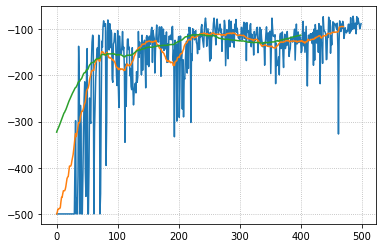

In [26]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(score_record)
plt.plot(running_mean(score_record,30))
plt.plot(running_mean(score_record,100))
# plt.plot(running_mean(running_mean(score_record,10),10))
# plt.ylim([0,500])
plt.grid(linestyle=":")

In [27]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.5.1296.video000000.mp4



SHOWING VIDEO video/openaigym.video.5.1296.video000100.mp4



SHOWING VIDEO video/openaigym.video.5.1296.video000200.mp4



SHOWING VIDEO video/openaigym.video.5.1296.video000300.mp4



SHOWING VIDEO video/openaigym.video.5.1296.video000400.mp4


## Final test

In [29]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=0)
    #   action, q_values = choose_action_softmax(policy_net, state, temperature=0)

      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -128.0
EPISODE 2 - FINAL SCORE: -112.0
EPISODE 3 - FINAL SCORE: -87.0
EPISODE 4 - FINAL SCORE: -85.0
EPISODE 5 - FINAL SCORE: -88.0
EPISODE 6 - FINAL SCORE: -79.0
EPISODE 7 - FINAL SCORE: -95.0
EPISODE 8 - FINAL SCORE: -92.0
EPISODE 9 - FINAL SCORE: -86.0
EPISODE 10 - FINAL SCORE: -88.0


In [30]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.7.1296.video000000.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000001.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000002.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000003.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000004.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000005.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000006.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000007.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000008.mp4



SHOWING VIDEO video/openaigym.video.7.1296.video000009.mp4
